In [0]:
#!pip install bayesian-optimization

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.metrics import accuracy_score,log_loss,f1_score
from sklearn.model_selection import KFold,StratifiedKFold   # K-fold CV    
from sklearn.metrics import classification_report
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings       
warnings.filterwarnings("ignore")
import numpy as np
from imblearn.over_sampling import SMOTE

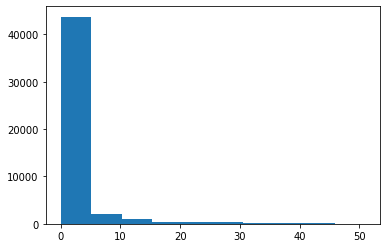

In [85]:
sell = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/공모전/동작구_공모전/sell_hump_150.csv',encoding='cp949')
sell.drop('Unnamed: 0',axis=1,inplace=True)
sell = sell[['x', 'y', 'old', 'child', 'crosswork','hump','accident']]
sell['accident'].value_counts()
plt.hist(sell['accident'])  #0/1~10/10~30/31~50

#파생변수 제작
sell.loc[sell['accident']==0,'label']=0
sell.loc[sell['accident']>0,'label']=1

sell.loc[sell['accident']==0,'multi_label']=0
sell.loc[(sell['accident']>0)&(sell['accident']<=20),'multi_label']=1
sell.loc[(sell['accident']>20)&(sell['accident']<=100),'multi_label']=2

X_data = sell[['old','child','crosswork','hump']]
y_data = sell['multi_label']
# X_data.replace([np.inf, -np.inf], 0, inplace=True)
# y_data.replace([np.inf, -np.inf], 0, inplace=True)
# X_data.fillna(0,inplace=True)
# y_data.fillna(0,inplace=True)

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=0.3,random_state=4321)

In [0]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha,reg_lambda, x_data=None, y_data=None, n_splits=5, output='model'):
    score = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=201)
    models = []
    sm = SMOTE(ratio='auto', kind='regular')
    for train_index, valid_index in skf.split(x_data,y_data):
       #print(train_index)
       x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
       
       #Smote
       sm = SMOTE(ratio='auto', kind='regular')
       # train데이터를 넣어 복제함
       X_resampled, y_resampled = sm.fit_sample(x_train,y_train)
       x_valid, y_valid = x_data.iloc[valid_index], y_data.iloc[valid_index]
        
       model = lgb.LGBMClassifier(
               
           num_leaves = int(num_leaves), 
           learning_rate = learning_rate, 
           n_estimators = int(n_estimators), 
           subsample = np.clip(subsample, 0, 1), 
           colsample_bytree = np.clip(colsample_bytree, 0, 1), 
           reg_alpha = reg_alpha, 
           reg_lambda = reg_lambda,
           )
       
       model.fit(X_resampled, y_resampled)
       models.append(model)
        
       pred = model.predict(x_valid)
       true = y_valid
       score += f1_score(true, pred,average='weighted')/n_splits
       
    if output == 'score':
        return score
    if output == 'model':
        return models

In [122]:
func_fixed = partial(lgb_cv, x_data=X_train, y_data=y_train, n_splits=5, output='score') 

lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),
        'learning_rate': (0.0001, 0.1),
        'n_estimators': (16, 2048),#1024),
        'subsample': (0, 1),
        'colsample_bytree': (0, 1),
        'reg_alpha': (0, 10), 
        'reg_lambda': (0, 50),
    }, 
    random_state=4321
)
lgbBO.maximize(init_points=5, n_iter=5) #30

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.6833   |  0.0708   |  0.08152  |  1.576e+0 |  304.6    |  1.931    |  48.95    |  0.4062   |
|  2        |  0.7023   |  0.7578   |  0.009006 |  645.7    |  639.9    |  4.599    |  10.92    |  0.6635   |
|  3        |  0.6872   |  0.6787   |  0.09504  |  587.5    |  640.8    |  3.833    |  20.02    |  0.9427   |
|  4        |  0.709    |  0.9299   |  0.09484  |  779.0    |  361.0    |  6.648    |  2.116    |  0.2322   |
|  5        |  0.6941   |  0.4301   |  0.007886 |  1.574e+0 |  876.7    |  1.504    |  5.057    |  0.2709   |
|  6        |  0.6856   |  0.5252   |  0.0451   |  1.036e+0 |  1.018e+0 |  6.265    |  43.51    |  0.9449   |
|  7        |  0.6842   |  0.1727   |  0.02629  |  2.045e+0 |  25.59    |  9.732    |  7.839    |  0.7189   |
|  8      

In [0]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'],   
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=X_train, y_data=y_train, n_splits=5, output='model')

In [106]:
preds = []
for model in models:
    pred = model.predict(X_test)
    preds.append(pred)

pred = np.mean(preds, axis=0)
f1_score(y_test, pred,average='weighted')

ValueError: ignored

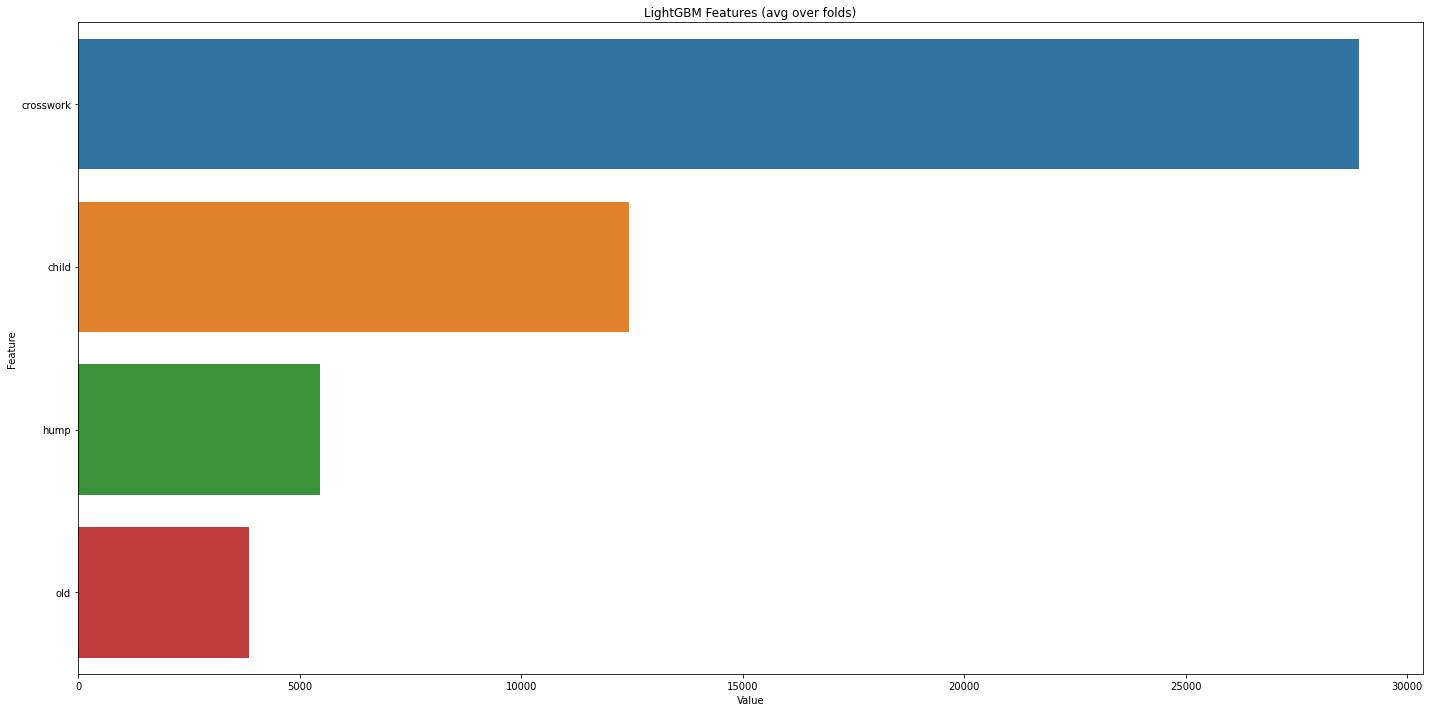

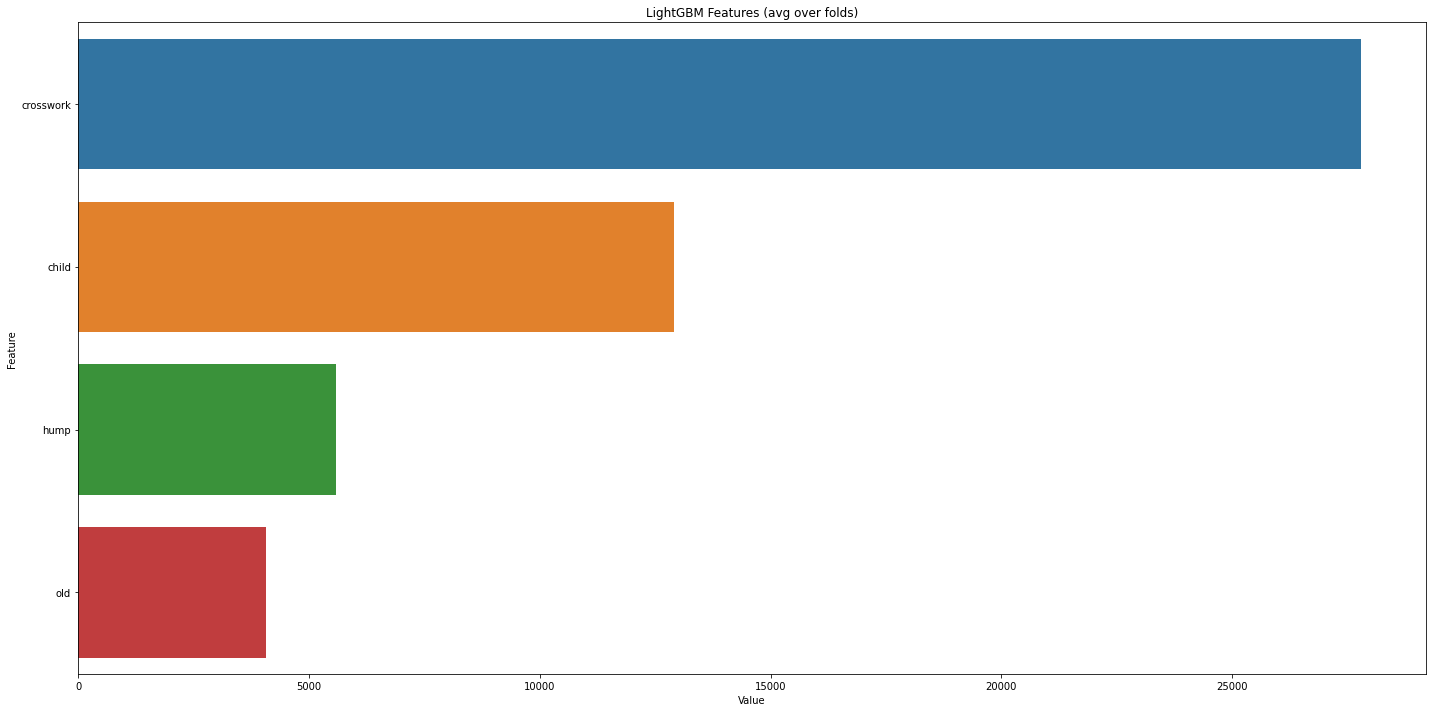

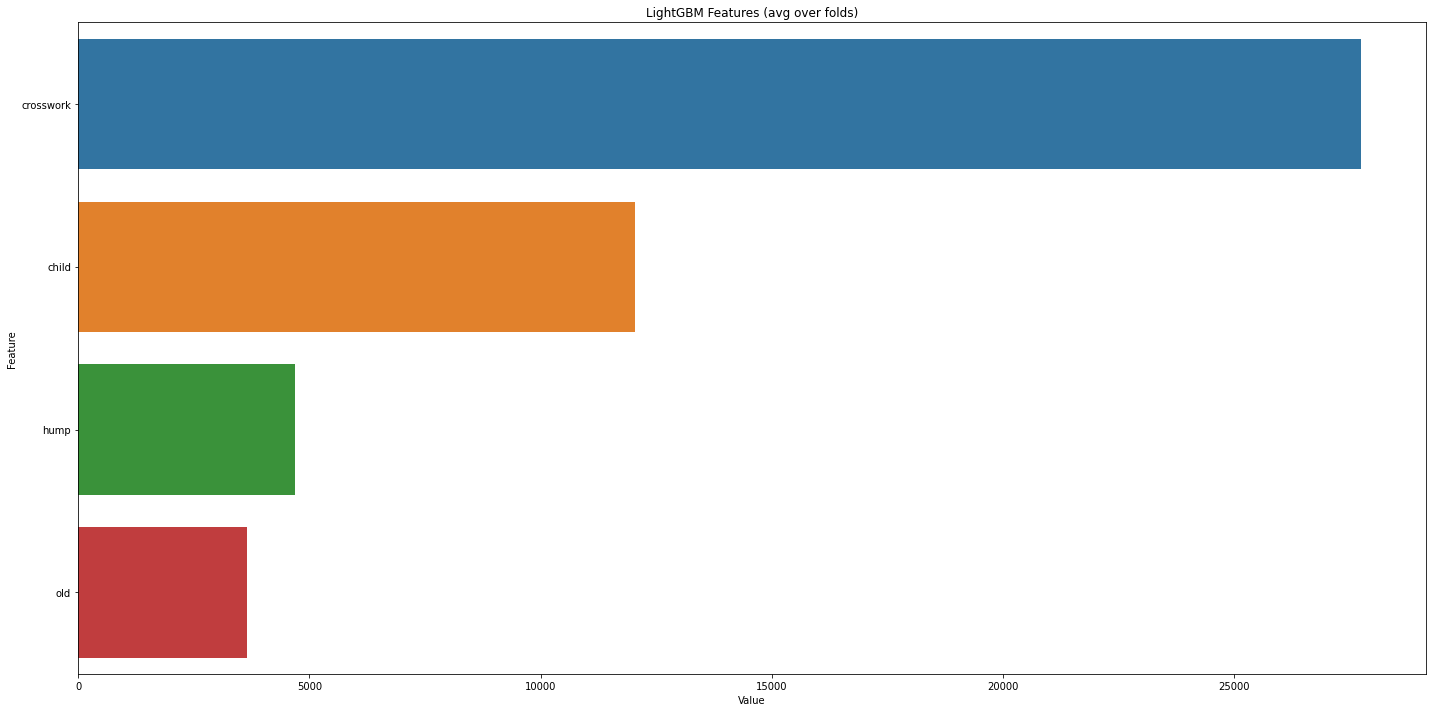

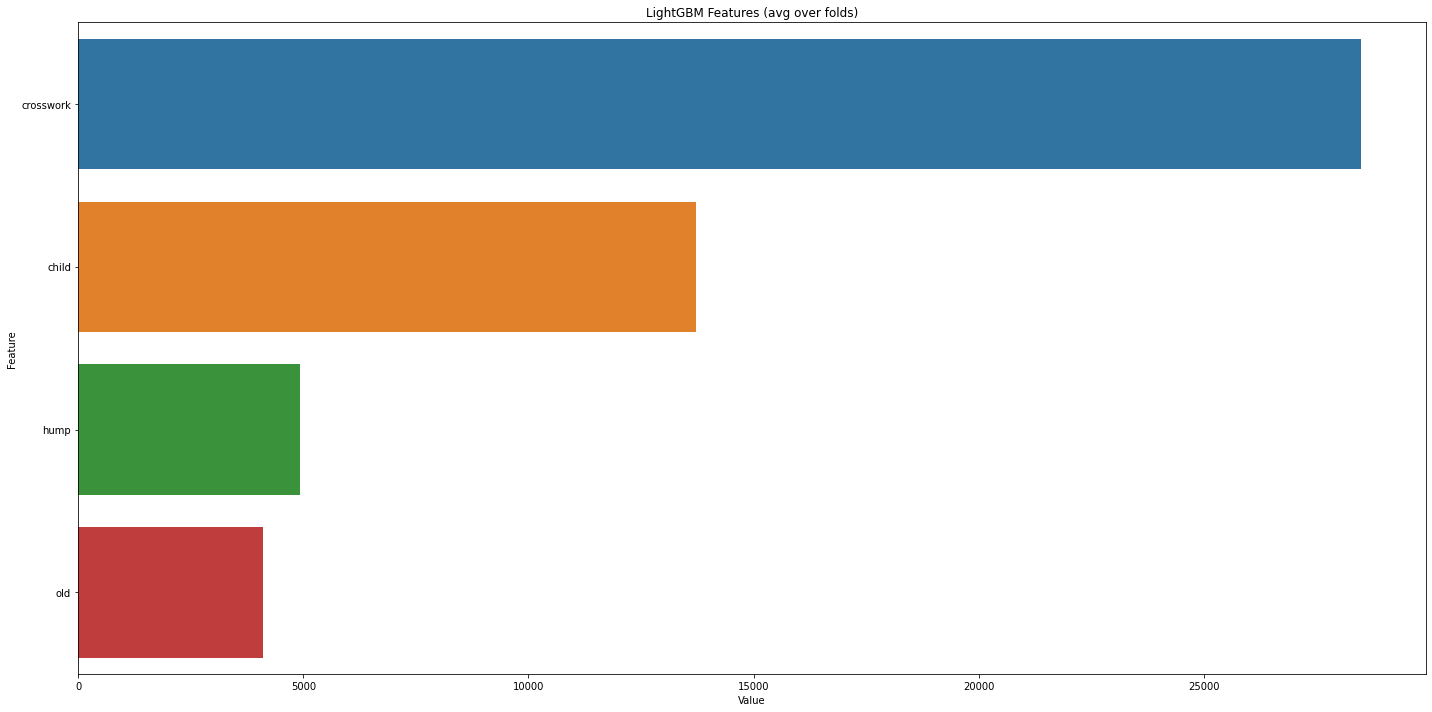

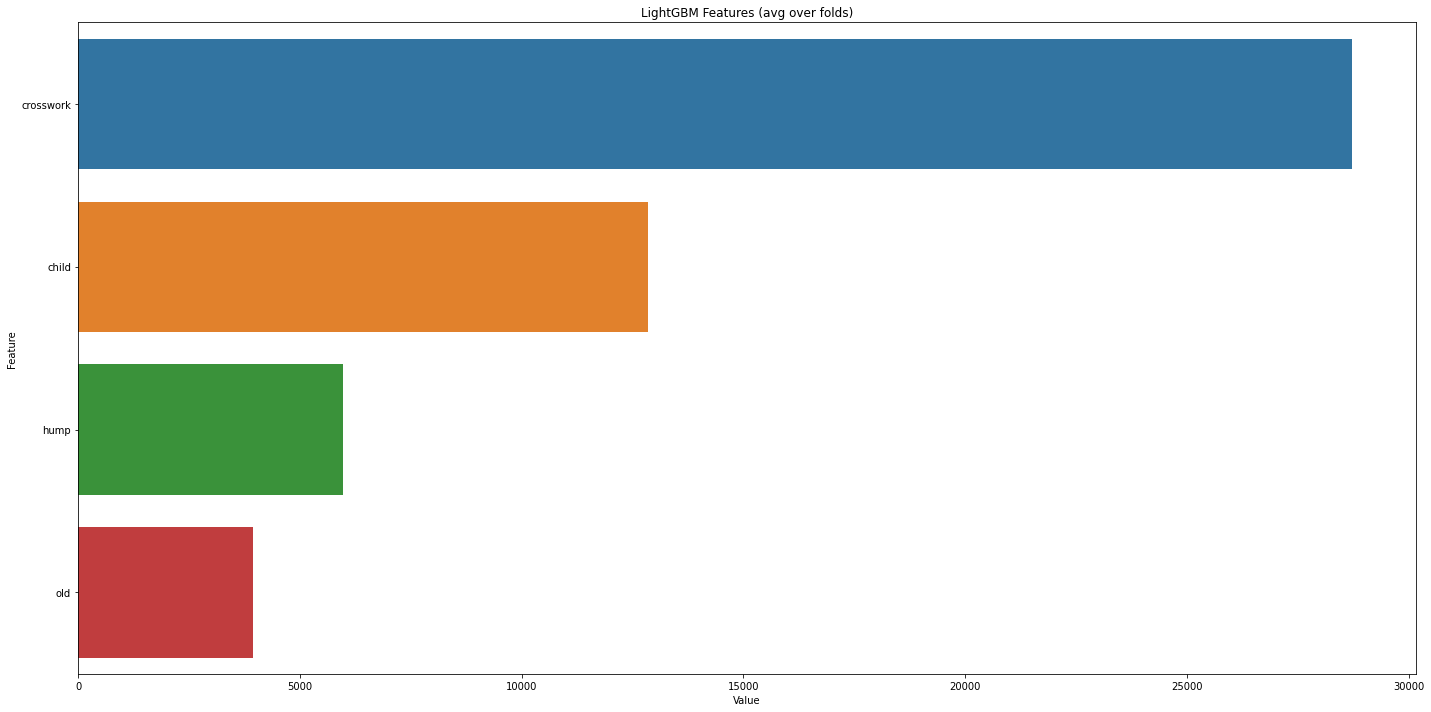

In [127]:
for model in models:
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()